In [1]:
# GET PARAMETERS
import os 
import sys
import pandas as pd
# Get Parent folder : 
current_path = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_path, '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from examples.train_and_visu_non_recurrent import evaluate_config,get_ds,train_the_config,get_ds_without_shuffling_on_train_set
from plotting.plotting import error_per_station_calendar_pattern,gain_between_models
from examples.train_model_on_k_fold_validation import load_configuration
from constants.paths import SAVE_DIRECTORY
from high_level_DL_method import load_model,load_optimizer_and_scheduler
from examples.load_best_config import load_args_of_a_specific_trial
from trainer import Trainer
import torch 

def get_trainer_and_ds_from_saved_trial(trial_id,add_name_id,save_folder,modification,fold_to_evaluate = None):
    # Load Data and Init Model:
    if fold_to_evaluate is None:
        fold_name = 'complete_dataset'
    else:
        fold_name = fold_to_evaluate[0]

    #args,_ = load_configuration(trial_id1,load_config=True)
    args = load_args_of_a_specific_trial(trial_id,add_name_id,save_folder,fold_name)

    if fold_to_evaluate is None:  fold_to_evaluate = [args.K_fold-1]

    
           
    ds,_,_,_,_ =  get_ds(args_init=args,modification = modification,fold_to_evaluate=fold_to_evaluate)
    model = load_model(ds, args)


    # Load Trained Weights 
    model_param = torch.load(f"{current_path}/{SAVE_DIRECTORY}/{save_folder}/best_models/{trial_id}{add_name_id}_f{fold_name}.pkl")
    model.load_state_dict(model_param['state_dict'],strict=True)


    # Load Trainer : 
    optimizer,scheduler,loss_function = load_optimizer_and_scheduler(model,args)
    trainer = Trainer(ds,model,args,optimizer,loss_function,scheduler = scheduler)

    return trainer,ds,args


Training and Hyper-parameter tuning with Ray is not possible


# Load Both models to compare : 

In [2]:
modification = {'shuffle':False,
                'data_augmentation':False }

# Load Model1:
save_folder1 = 'K_fold_validation/training_with_HP_tuning/re_validation'
add_name_id1 = ''
trial_id1 ='subway_in_STGCN_MSELoss_2025_01_20_14_27_20569'
trainer1,ds1,args1 = get_trainer_and_ds_from_saved_trial(trial_id1,add_name_id1,save_folder1,modification)

# Load Model2: 
save_folder2 = 'K_fold_validation/training_with_HP_tuning/re_validation'
add_name_id2 = 'concat_early'
trial_id2 ='subway_in_subway_out_STGCN_VariableSelectionNetwork_MSELoss_2025_01_20_05_38_87836' 
trainer2,ds2,args2 = get_trainer_and_ds_from_saved_trial(trial_id2,add_name_id2,save_folder2,modification)

>>>>Model: STGCN; K_fold = 6; Loss function: MSE 


Invalid dates within this fold: 776

Init Dataset: 'torch.Size([7392, 40]) with 295680 Total nb of elements and 0 Nan values
Init U/Utarget size: torch.Size([4702, 40, 7])/torch.Size([4702, 40, 1]) Train/Valid/Test 2821 940 940

 ===== ERROR WITH prefetch_factor====  
ValueError: prefetch_factor option could only be specified in multiprocessing.let num_workers > 0 to enable multiprocessing
Invalid dates within this fold: 481

Init Dataset: 'torch.Size([4597, 40]) with 183880 Total nb of elements and 0 Nan values
Init U/Utarget size: torch.Size([2940, 40, 7])/torch.Size([2940, 40, 1]) Train/Valid/Test 1059 941 939

 ===== ERROR WITH prefetch_factor====  
ValueError: prefetch_factor option could only be specified in multiprocessing.let num_workers > 0 to enable multiprocessing
Model size: 0.000GB
number of total parameters: 71713
number of trainable parameters: 71713
>>>>Model: STGCN; K_fold = 6; Loss function: MSE 
Invalid dates within this fold: 776

Init Dataset: 'torch.Size([7392, 40

## Get Metrics from trained model. Compared consistency with saved one : 
Nous permets de nous assurer qu'on à bien sauvegarder le meiolleur model, et que c'est bien celui qu'on Load.

In [3]:
def display_consistency(trainer1,ds1,save_folder1,trial_id1,add_name_id1,training_mode = 'test'):
    full_predict1,Y_true,_ = trainer1.testing(ds1.normalizer, training_mode =training_mode)
    Y_true= Y_true.detach().clone().reshape(-1)    
    full_predict1= full_predict1.detach().clone().reshape(-1)    
    error_pred1 = ((Y_true - full_predict1)**2).mean()

    df_metrics1 = pd.read_csv(f"{current_path}/{SAVE_DIRECTORY}/{save_folder1}/METRICS_{trial_id1}{add_name_id1}.csv")
    display(df_metrics1)
    print(f"MSE errror on {training_mode} by loading trained model : {'{:.2f}'.format(error_pred1.item())}")

if True:
    display_consistency(trainer2,ds2,save_folder2,trial_id2,add_name_id2,training_mode = 'test')

,Unnamed: 0,mse,mae,mape,VAR_mse,VAR_mae,VAR_mape,mse_complete_ds,mae_complete_ds,mape_complete_ds
0,valid,1230.919019,20.847181,36.719215,5382.383880,0.558646,6.967195,1128.664185,19.996849,33.227039
1,test,1288.185107,21.260062,36.229020,4998.188979,1.045187,84.935830,1286.441650,20.617752,29.995420


MSE errror on test by loading trained model : 1286.44


## Plot Gains between Two trained Models:
Retourne le gain de Model 2 par rapport à Model 1

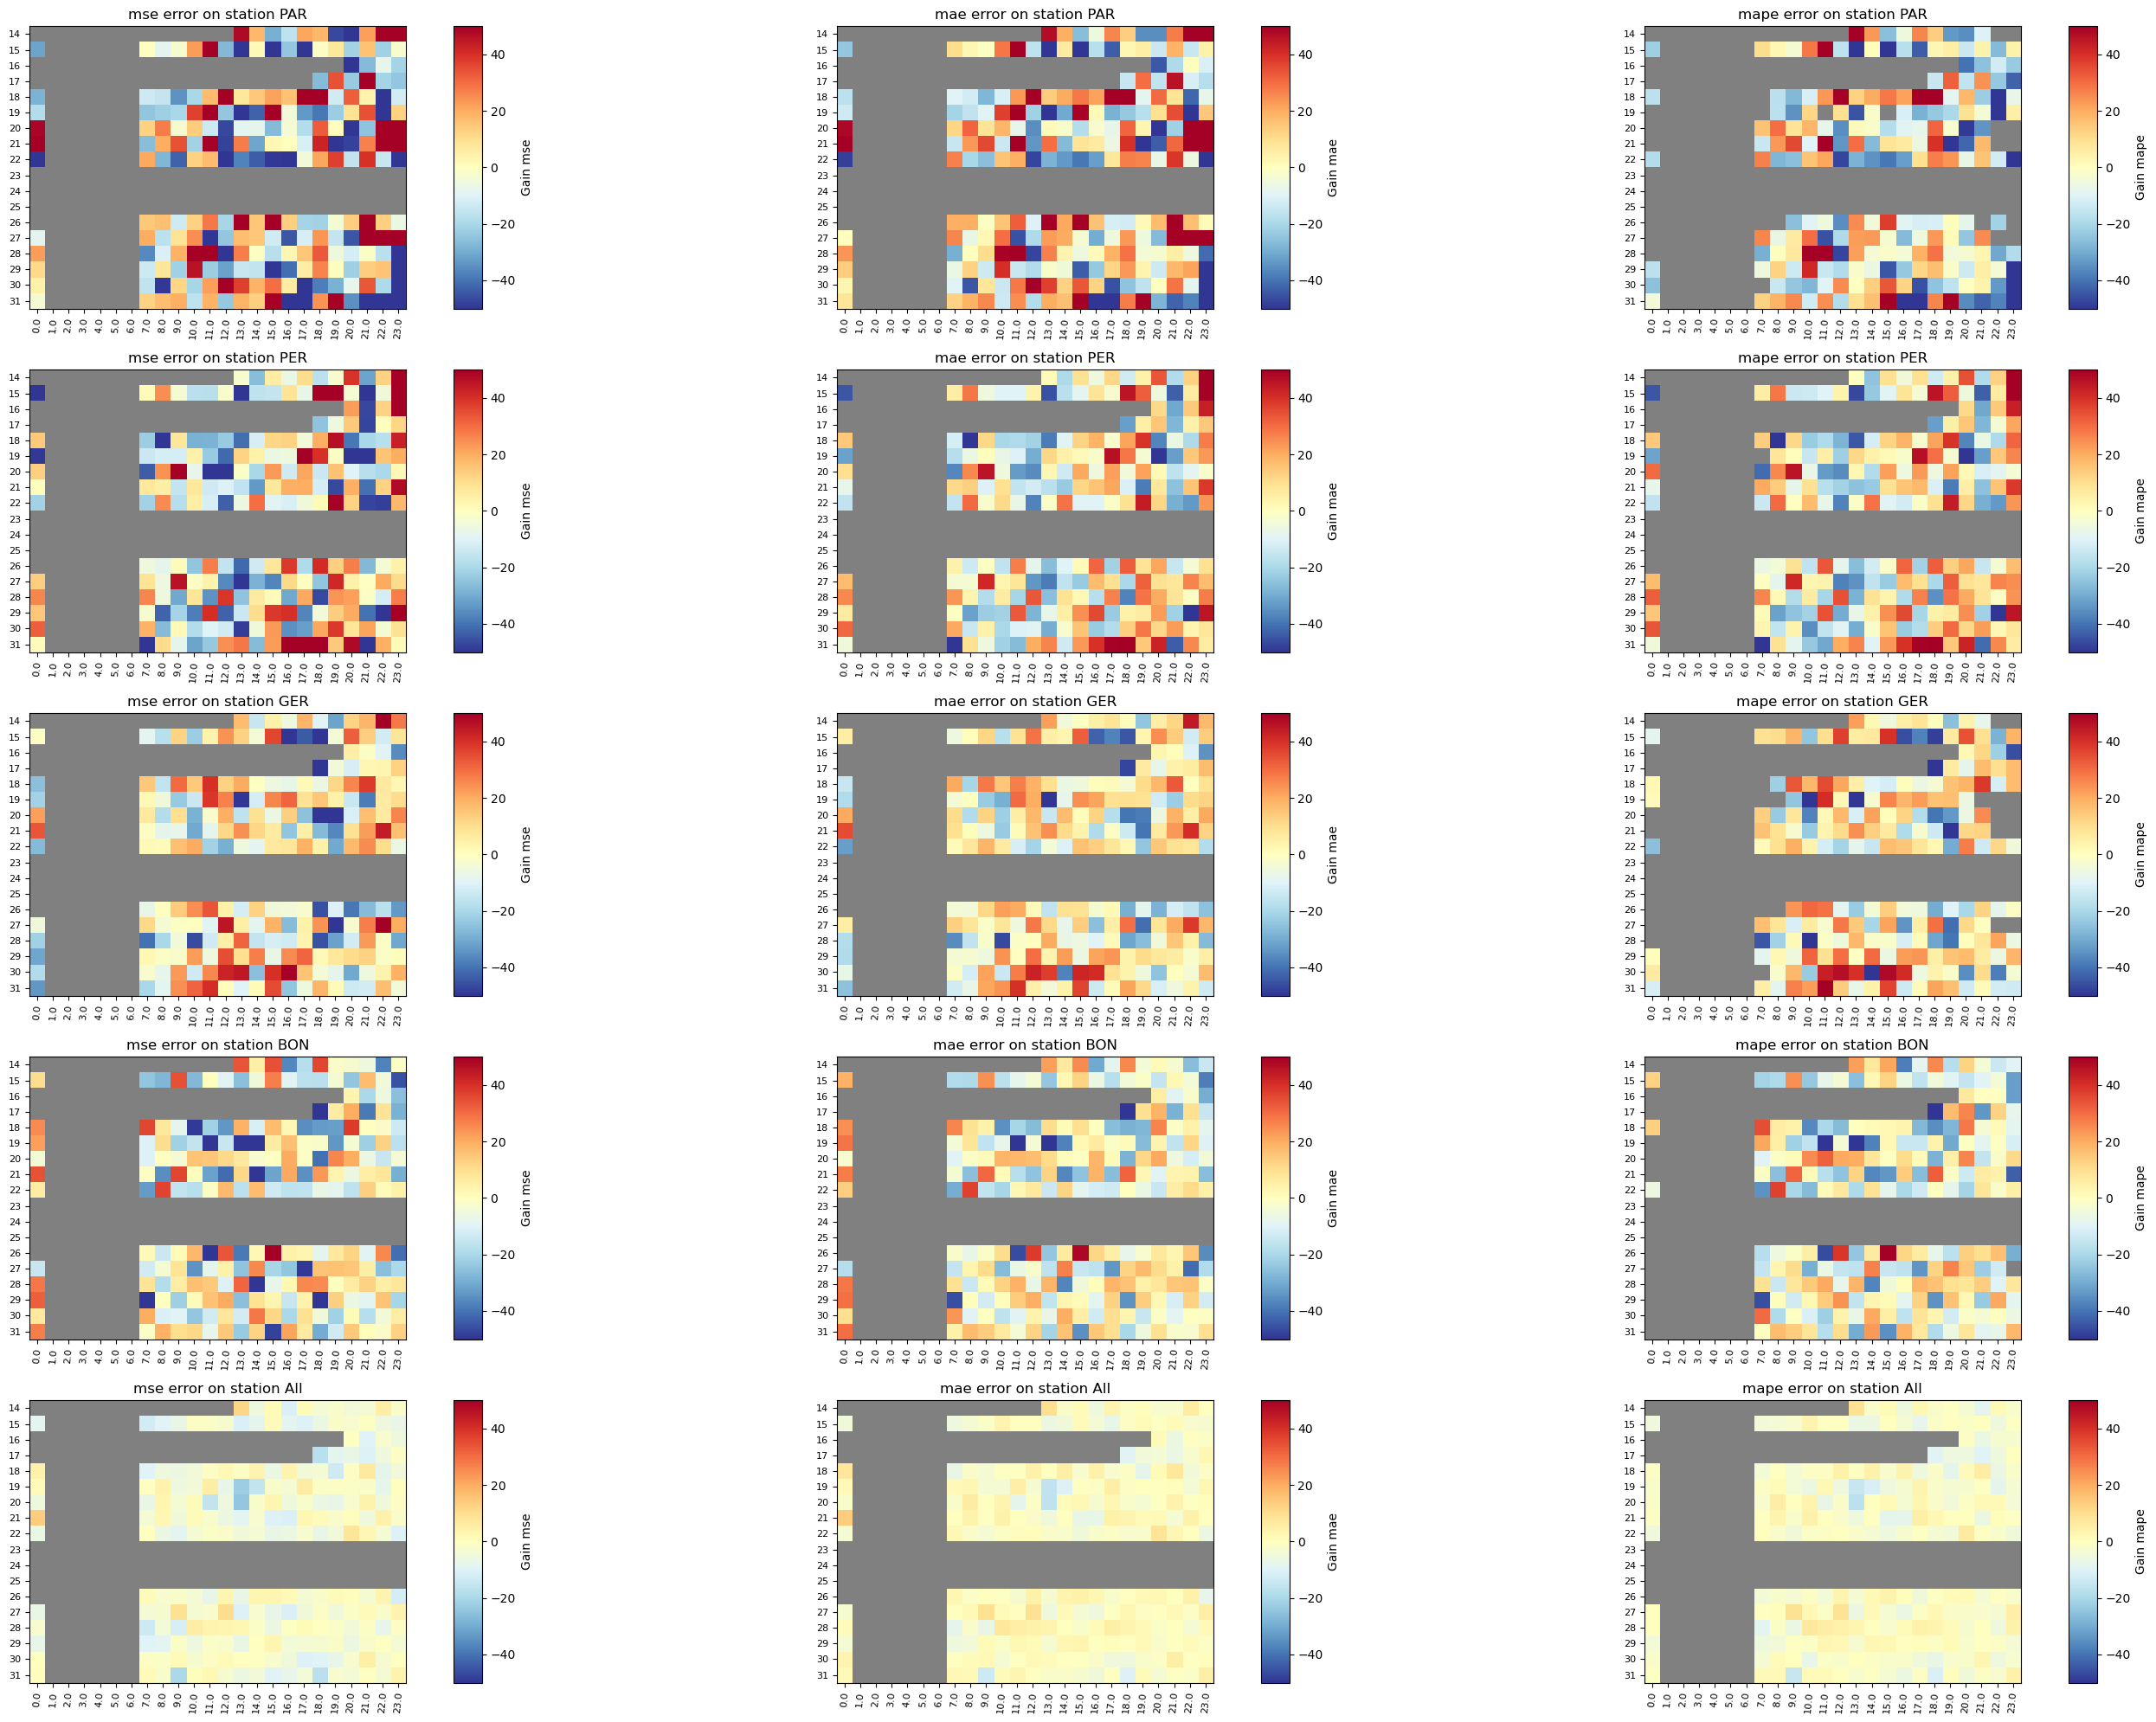

(<Figure size 3000x2000 with 30 Axes>,
 array([[<Axes: title={'center': 'mse error on station PAR'}>,
         <Axes: title={'center': 'mae error on station PAR'}>,
         <Axes: title={'center': 'mape error on station PAR'}>],
        [<Axes: title={'center': 'mse error on station PER'}>,
         <Axes: title={'center': 'mae error on station PER'}>,
         <Axes: title={'center': 'mape error on station PER'}>],
        [<Axes: title={'center': 'mse error on station GER'}>,
         <Axes: title={'center': 'mae error on station GER'}>,
         <Axes: title={'center': 'mape error on station GER'}>],
        [<Axes: title={'center': 'mse error on station BON'}>,
         <Axes: title={'center': 'mae error on station BON'}>,
         <Axes: title={'center': 'mape error on station BON'}>],
        [<Axes: title={'center': 'mse error on station All'}>,
         <Axes: title={'center': 'mae error on station All'}>,
         <Axes: title={'center': 'mape error on station All'}>]],
     

In [4]:
station = ['PAR','PER','GER','BON']
training_mode = 'test'
gain_between_models(trainer1,trainer2,ds1,ds2,training_mode,
                         metrics = ['mse','mae','mape'],
                        freq='1h',
                        index_matshow = 'day_date',
                        columns_matshow = 'hour',
                        min_flow = 20,
                        figsize = (30,5*len(station)),
                        limit_percentage_error = 50,
                        acceptable_error = 10,
                        stations = station)

## Visualisation des coeff d'attentions :

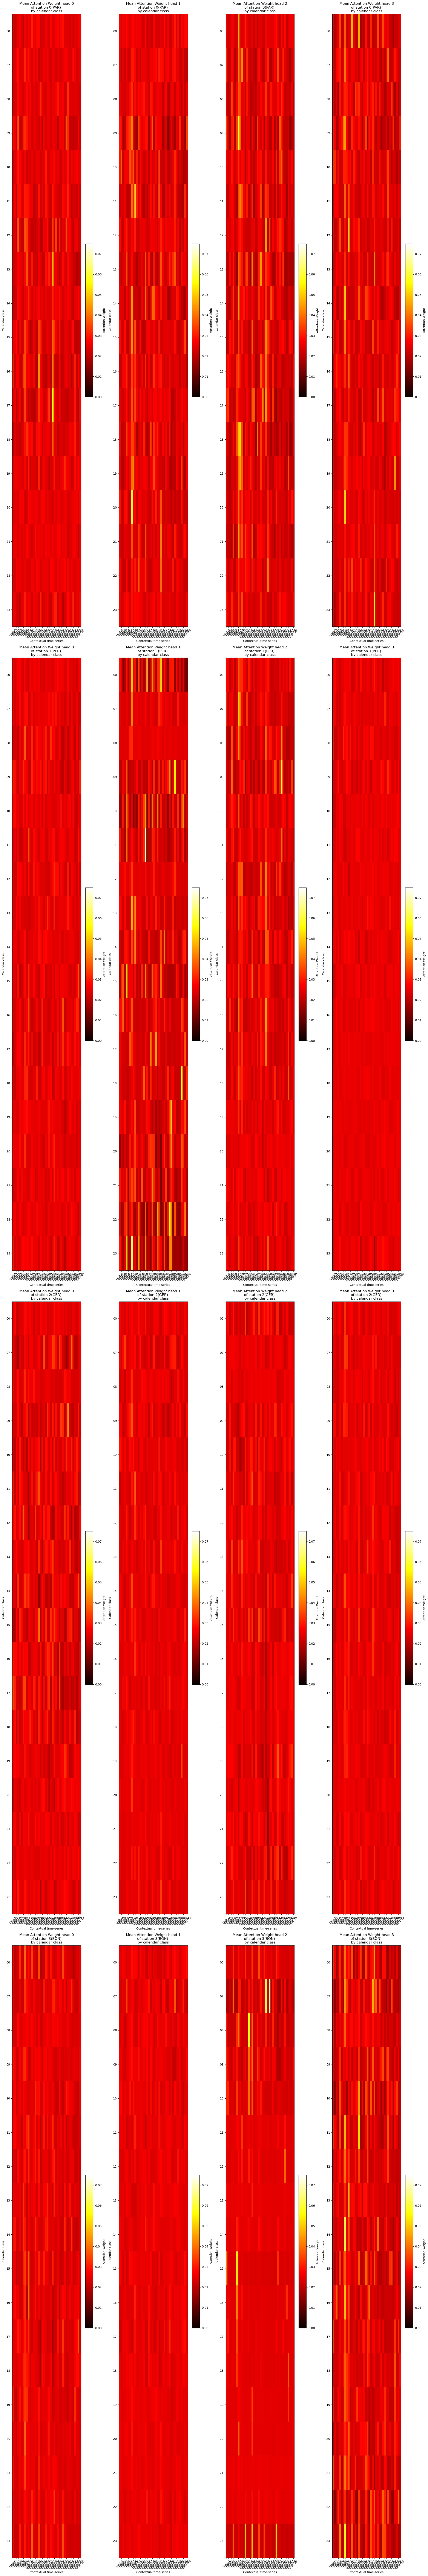

In [39]:
from plotting.plotting import plot_attn_weight
from constants.paths import CALENDAR_TYPE
nb_calendar_data = len(CALENDAR_TYPE)
temporal_agg = 'hour'  # weekday_hour_minutes','hour','weekday','weekday_hour'
plot_attn_weight(trainer2,nb_calendar_data,ds1,training_mode = training_mode,stations= station,temporal_agg =temporal_agg,save=None)